In [1]:
# ==========================
# Imports & config
# ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ✅ Path to your EMNIST CSV files
BASE_DIR = r"C:\Users\samin\Desktop\humanActivity\UCI HAR Dataset"

print("Files:", os.listdir(BASE_DIR))


Files: ['emnist-balanced-mapping.txt', 'emnist-balanced-test.csv', 'emnist-balanced-train.csv', 'emnist-byclass-mapping.txt', 'emnist-byclass-test.csv', 'emnist-byclass-train.csv', 'emnist-bymerge-mapping.txt', 'emnist-bymerge-test.csv', 'emnist-bymerge-train.csv', 'emnist-digits-mapping.txt', 'emnist-digits-test.csv', 'emnist-digits-train.csv', 'emnist-letters-mapping.txt', 'emnist-letters-test.csv', 'emnist-letters-train.csv', 'emnist-mnist-mapping.txt', 'emnist-mnist-test.csv', 'emnist-mnist-train.csv', 'emnist_source_files']


In [2]:
# ==================================
#  EMNIST loader (CSV files)
# ==================================

def load_emnist(variant="digits", limit=None):
    """
    Loads EMNIST variant from local CSV files.

    variant: 'balanced', 'digits', 'letters', 'mnist', 'byclass', 'bymerge'
    limit:   optionally limit number of samples (for quick experiments)
    """
    train_path = os.path.join(BASE_DIR, f"emnist-{variant}-train.csv")
    test_path  = os.path.join(BASE_DIR, f"emnist-{variant}-test.csv")

    print("Loading train:", train_path)
    print("Loading test :", test_path)

    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    if limit is not None:
        train_df = train_df.iloc[:limit]
        test_df  = test_df.iloc[:limit]

    # First column = label, others = 784 pixels
    y_train = train_df.iloc[:, 0].values.astype("int64")
    X_train = train_df.iloc[:, 1:].values.astype("float32")

    y_test  = test_df.iloc[:, 0].values.astype("int64")
    X_test  = test_df.iloc[:, 1:].values.astype("float32")

    # Normalise to [0, 1]
    X_train /= 255.0
    X_test  /= 255.0

    # Flat inputs (for MLP)
    X_train_flat = X_train.copy()
    X_test_flat  = X_test.copy()

    # 28×28×1 images (for CNN / AE)
    X_train_img = X_train.reshape(-1, 28, 28, 1)
    X_test_img  = X_test.reshape(-1, 28, 28, 1)

    num_classes = len(np.unique(y_train))
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes)

    print("X_train_img:", X_train_img.shape)
    print("X_test_img :", X_test_img.shape)
    print("num_classes:", num_classes)

    return (
        X_train_flat, X_test_flat,
        X_train_img,  X_test_img,
        y_train,      y_test,
        y_train_oh,   y_test_oh,
        num_classes
    )

In [3]:
# ==========================
# Load EMNIST data
# ==========================

VARIANT = "digits"     # options: 'digits', 'balanced', 'letters', 'mnist', 'byclass', 'bymerge'
LIMIT   = None         # or e.g. 50000 for faster experiments

(
    X_train_flat, X_test_flat,
    X_train_img,  X_test_img,
    y_train,      y_test,
    y_train_oh,   y_test_oh,
    num_classes
) = load_emnist(VARIANT, limit=LIMIT)

print("\nLoaded variant:", VARIANT)
print("Train size:", X_train_img.shape[0])
print("Test size :", X_test_img.shape[0])


Loading train: C:\Users\samin\Desktop\humanActivity\UCI HAR Dataset\emnist-digits-train.csv
Loading test : C:\Users\samin\Desktop\humanActivity\UCI HAR Dataset\emnist-digits-test.csv
X_train_img: (239999, 28, 28, 1)
X_test_img : (39999, 28, 28, 1)
num_classes: 10

Loaded variant: digits
Train size: 239999
Test size : 39999


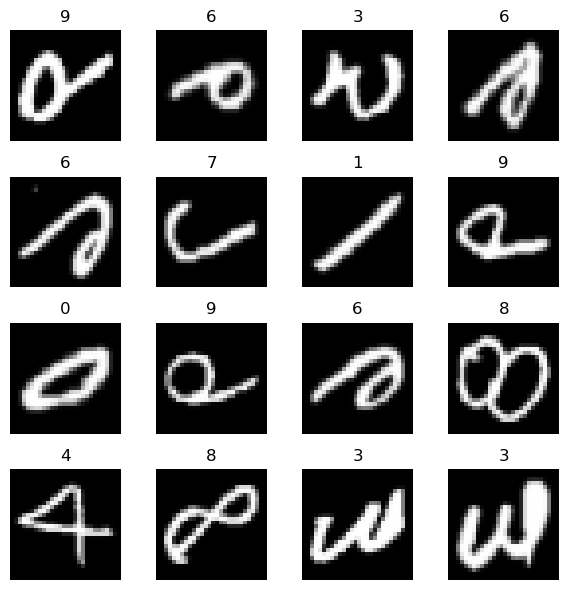

In [4]:
# =====================================
# some sample images
# =====================================
def show_samples(X, y, n=16):
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(X[i].reshape(28,28), cmap="gray")
        plt.title(int(y[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X_train_img, y_train, n=16)


In [5]:
# ======================================
#  MLP Classification
# ======================================

def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

mlp_model = build_mlp(784, num_classes)
mlp_model.summary()

history_mlp = mlp_model.fit(
    X_train_flat, y_train_oh,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

y_pred_mlp = np.argmax(mlp_model.predict(X_test_flat), axis=1)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp  = f1_score(y_test, y_pred_mlp, average="weighted")
print(f"\nMLP – Test Accuracy: {acc_mlp:.4f}, F1: {f1_mlp:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9498 - loss: 0.1693 - val_accuracy: 0.9805 - val_loss: 0.0678
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9749 - loss: 0.0858 - val_accuracy: 0.9843 - val_loss: 0.0533
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9794 - loss: 0.0698 - val_accuracy: 0.9847 - val_loss: 0.0536
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9811 - loss: 0.0634 - val_accuracy: 0.9853 - val_loss: 0.0486
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9831 - loss: 0.0569 - val_accuracy: 0.9860 - val_loss: 0.0439
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9840 - loss: 0.0541 - val_accuracy: 0.9884 - val_loss: 0.0389
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9853 - loss: 0.0507 - val_accuracy: 0.9886 - val_loss: 0.0383
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9854 -

In [6]:
# ==========================================
#  CNN Classification (deep)
# ==========================================

def build_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

cnn_model = build_cnn(num_classes)
cnn_model.summary()

history_cnn = cnn_model.fit(
    X_train_img, y_train_oh,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

y_pred_cnn = np.argmax(cnn_model.predict(X_test_img), axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
f1_cnn  = f1_score(y_test, y_pred_cnn, average="weighted")
print(f"\nCNN – Test Accuracy: {acc_cnn:.4f}, F1: {f1_cnn:.4f}")


C:\Users\samin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,018 (3.32 MB)

 Trainable params: 870,826 (3.32 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 276s 161ms/step - accuracy: 0.9559 - loss: 0.1521 - val_accuracy: 0.9904 - val_loss: 0.0318
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 269s 159ms/step - accuracy: 0.9858 - loss: 0.0536 - val_accuracy: 0.9935 - val_loss: 0.0253
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 280s 166ms/step - accuracy: 0.9893 - loss: 0.0402 - val_accuracy: 0.9925 - val_loss: 0.0253
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 275s 163ms/step - accuracy: 0.9914 - loss: 0.0336 - val_accuracy: 0.9951 - val_loss: 0.0226
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 276s 164ms/step - accuracy: 0.9922 - loss: 0.0299 - val_accuracy: 0.9940 - val_loss: 0.0261
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 278s 165ms/step - accuracy: 0.9930 - loss: 0.0273 - val_accuracy: 0.9956 - val_loss: 0.0189
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 275s 163ms/step - accuracy: 0.9934 - loss: 0.0254 - val_accuracy: 0.9940 - val_loss: 0.0263
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 291s 172ms/step - ac

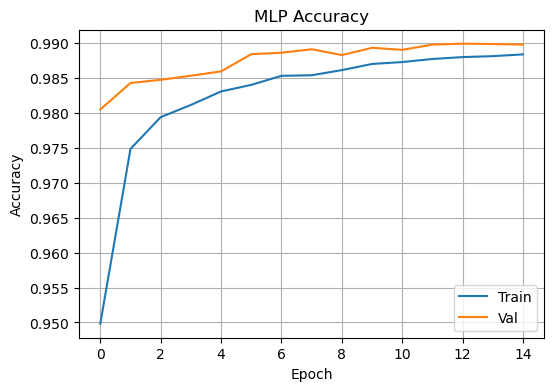

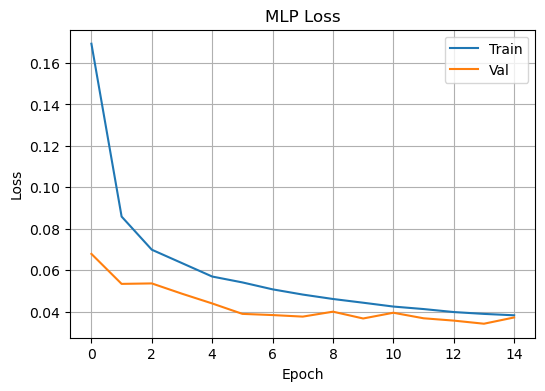

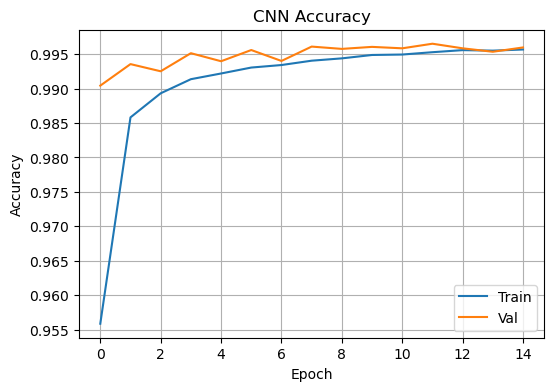

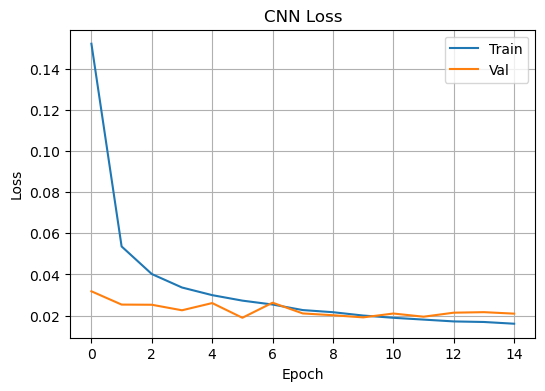

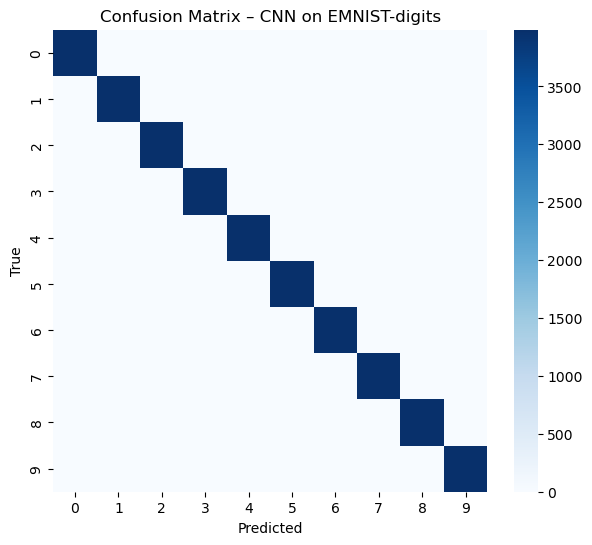

In [7]:
# ======================================================
#  Loss/Accuracy & Confusion Matrix (CNN)
# ======================================================

def plot_history(history, title_prefix):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend(); plt.grid(True); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend(); plt.grid(True); plt.show()

plot_history(history_mlp, "MLP")
plot_history(history_cnn, "CNN")

cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(7,6))
sns.heatmap(cm, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – CNN on EMNIST-{VARIANT}")
plt.show()


Model: "AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,369 (1.06 MB)

 Trainable params: 278,369 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 159s 178ms/step - loss: 0.1721 - val_loss: 0.1251
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 149s 176ms/step - loss: 0.1225 - val_loss: 0.1209
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 168ms/step - loss: 0.1199 - val_loss: 0.1193
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 147s 175ms/step - loss: 0.1187 - val_loss: 0.1183
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 152s 180ms/step - loss: 0.1180 - val_loss: 0.1177
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 146s 172ms/step - loss: 0.1174 - val_loss: 0.1173
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 145s 172ms/step - loss: 0.1171 - val_loss: 0.1170
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 154s 182ms/step - loss: 0.1168 - val_loss: 0.1168
Epoch 9/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 130s 153ms/step - loss: 0.1165 - val_loss: 0.1165
Epoch 10/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 124s 147ms/step - loss: 0.1164 - val_loss: 0.1163


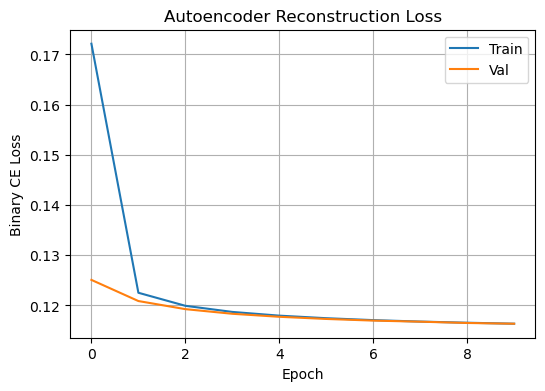

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Latent Z_train: (239999, 32)


In [8]:
# =================================================
#  Autoencoder
# =================================================
def build_autoencoder(latent_dim=32):
    inp = layers.Input(shape=(28,28,1), name="ae_input")

    # Encoder
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # Decoder
    x = layers.Dense(7*7*64, activation="relu")(latent)
    x = layers.Reshape((7,7,64))(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)
    out = layers.Conv2D(1, (3,3), padding="same", activation="sigmoid")(x)

    auto = models.Model(inp, out, name="AE")
    enc  = models.Model(inp, latent, name="Encoder")
    auto.compile(optimizer="adam", loss="binary_crossentropy")
    return auto, enc

autoencoder, encoder = build_autoencoder(latent_dim=32)
autoencoder.summary()

history_ae = autoencoder.fit(
    X_train_img, X_train_img,
    validation_split=0.1,
    epochs=10,
    batch_size=256,
    verbose=1
)
plt.figure(figsize=(6,4))
plt.plot(history_ae.history["loss"], label="Train")
plt.plot(history_ae.history["val_loss"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Binary CE Loss")
plt.title("Autoencoder Reconstruction Loss")
plt.legend(); plt.grid(True); plt.show()

# Extract latent features
Z_train = encoder.predict(X_train_img)
Z_test  = encoder.predict(X_test_img)
print("Latent Z_train:", Z_train.shape)


Cluster counts: [1366  739  900 1208 1269 1001 1081  956  657  823]
PCA 2D shape: (10000, 2)


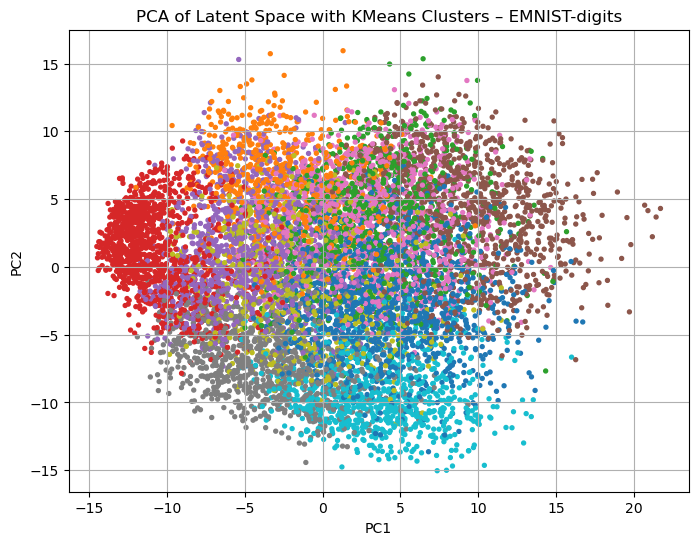

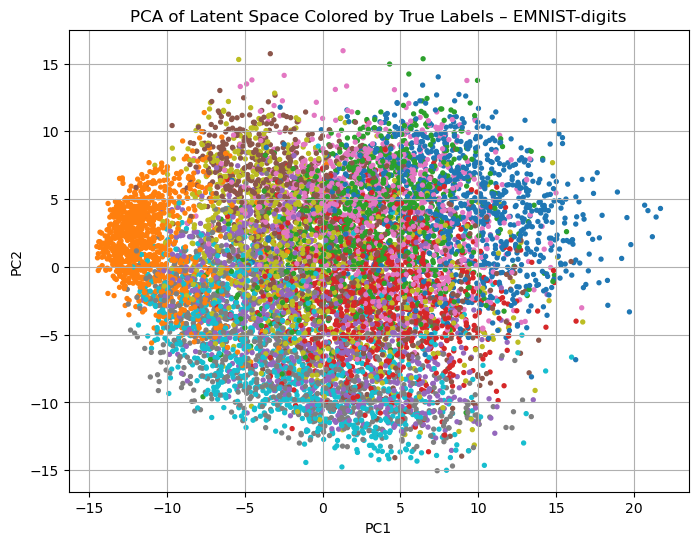

In [9]:
# ===================================================
#  PCA + KMeans on latent space (clustering)
# ===================================================

# For visualisation, you can subsample if huge:
max_points = 10000
if Z_train.shape[0] > max_points:
    idx = np.random.choice(Z_train.shape[0], max_points, replace=False)
    Z_used = Z_train[idx]
    y_used = y_train[idx]
else:
    Z_used = Z_train
    y_used = y_train

# KMeans clustering
kmeans = KMeans(n_clusters=num_classes, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(Z_used)
print("Cluster counts:", np.bincount(cluster_labels))

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
Z_2d = pca.fit_transform(Z_used)
print("PCA 2D shape:", Z_2d.shape)

# Plot by cluster label
plt.figure(figsize=(8,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=cluster_labels, s=8, cmap="tab10")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA of Latent Space with KMeans Clusters – EMNIST-{VARIANT}")
plt.grid(True)
plt.show()

# Plot by TRUE digit label
plt.figure(figsize=(8,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=y_used, s=8, cmap="tab10")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA of Latent Space Colored by True Labels – EMNIST-{VARIANT}")
plt.grid(True)
plt.show()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step


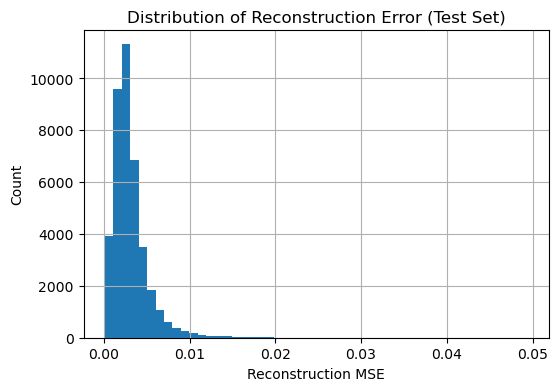

Anomaly threshold: 0.011544
Number of anomalies (top 1%): 400


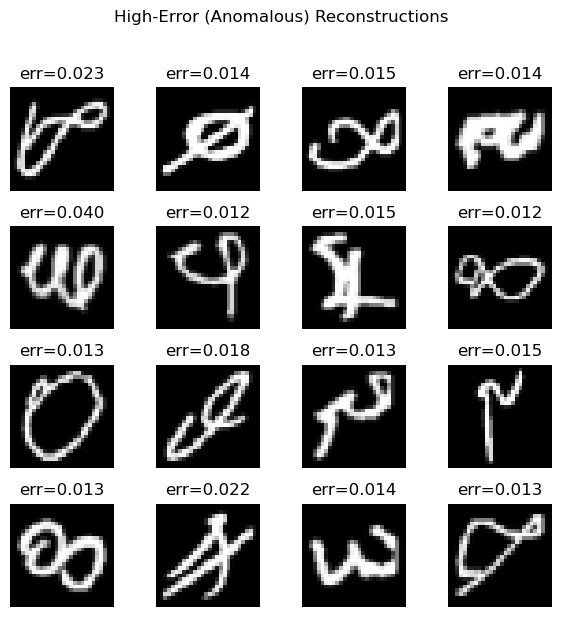

In [10]:
# =========================================================
#  Anomaly-style detection (recon error)
# =========================================================

# Reconstruction error on test set
X_test_recon = autoencoder.predict(X_test_img)
recon_error = np.mean((X_test_img - X_test_recon)**2, axis=(1,2,3))

plt.figure(figsize=(6,4))
plt.hist(recon_error, bins=50)
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Distribution of Reconstruction Error (Test Set)")
plt.grid(True)
plt.show()

# Flag top 1% highest error as "anomalies"
threshold = np.percentile(recon_error, 99)
anomaly_indices = np.where(recon_error >= threshold)[0]
print(f"Anomaly threshold: {threshold:.6f}")
print(f"Number of anomalies (top 1%): {len(anomaly_indices)}")

# Visualise some anomalies
n_show = min(16, len(anomaly_indices))
plt.figure(figsize=(6,6))
for i in range(n_show):
    idx = anomaly_indices[i]
    plt.subplot(4,4,i+1)
    plt.imshow(X_test_img[idx].reshape(28,28), cmap="gray")
    plt.title(f"err={recon_error[idx]:.3f}")
    plt.axis("off")
plt.suptitle("High-Error (Anomalous) Reconstructions", y=1.02)
plt.tight_layout()
plt.show()
